# Training routines using the CaseHold Data


In [1]:
!pip3 install torch torchtext torchdata -U
!pip3 install tqdm
!pip3 install argparse
!pip3 install collections
!pip3 install datasets
# !pip3 install sentence_transformers
!pip3 install transformers
# !pip3 install tensorflow==2.14
!pip3 install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.7.0
    Uninstalling 

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [51]:
import os
import json
import re
import string
import random
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from argparse import Namespace
from tqdm import tqdm_notebook
from datasets import Dataset

import transformers
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer

import torch.nn.functional as F
import torch

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
casehold_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CS4099-LegalNLP/raw_data/casehold.csv')



In [15]:
context_lengths = [len(text) for text in casehold_df['1']]

holding_lengths = [len(text) for text in casehold_df[str(i)] for i in range(2,7)]

(array([2.6000e+01, 3.8000e+01, 4.7000e+01, 6.1000e+01, 7.6000e+01,
        7.3000e+01, 9.0000e+01, 2.1990e+03, 5.0107e+04, 0.0000e+00]),
 array([ 200.,  280.,  360.,  440.,  520.,  600.,  680.,  760.,  840.,
         920., 1000.]),
 <BarContainer object of 10 artists>)

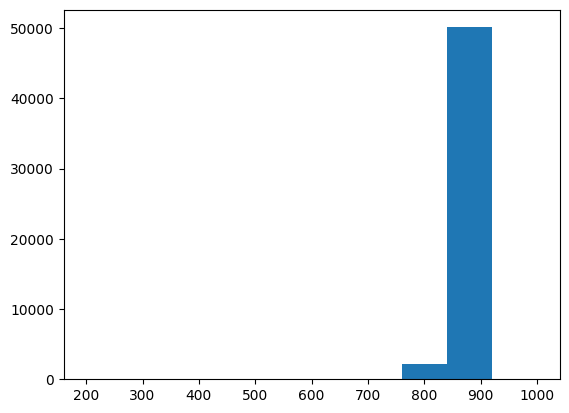

In [20]:
plt.hist(context_lengths, range=(200, 1000))


(array([2.32765e+05, 3.03500e+04, 9.95000e+02, 1.50000e+02, 5.00000e+00,
        5.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.50000e+01]),
 array([  12. ,  243.2,  474.4,  705.6,  936.8, 1168. , 1399.2, 1630.4,
        1861.6, 2092.8, 2324. ]),
 <BarContainer object of 10 artists>)

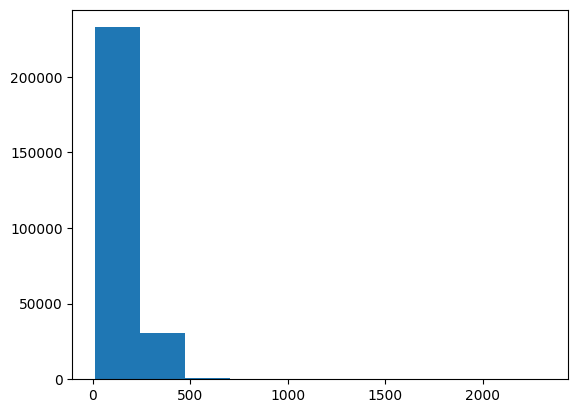

In [19]:
plt.hist(holding_lengths)

In [23]:
test = casehold_df['1'][0]

In [42]:
tokenizer= AutoTokenizer.from_pretrained("casehold/legalbert")

In [43]:
input_ids = tokenizer(test).input_ids
subword_view = [tokenizer.convert_ids_to_tokens(id) for id in input_ids]
np.array(subword_view)

array(['[CLS]', 'dr', '##ape', '##au', '’', 's', 'co', '##hort', '##s',
       ',', 'the', 'co', '##hort', 'would', 'be', 'a', '“', 'victim', '”',
       'of', 'making', 'the', 'bomb', '.', 'further', ',', 'fire', '##bo',
       '##mbs', 'are', 'inherently', 'dangerous', '.', 'there', 'is',
       'no', 'peaceful', 'purpose', 'for', 'making', 'a', 'bomb', '.',
       'felony', 'offenses', 'that', 'involve', 'explosives', 'qualify',
       'as', '“', 'violent', 'crimes', '”', 'for', 'purposes', 'of',
       'enhancing', 'the', 'sentences', 'of', 'career', 'offenders', '.',
       'see', '18', 'u', '.', 's', '.', 'c', '.', '§', '92', '##4', '(',
       'e', ')', '(', '2', ')', '(', 'b', ')', '(', 'ii', ')', '(',
       'defining', 'a', '“', 'violent', 'felony', '”', 'as', ':', '“',
       'any', 'crime', 'punish', '##able', 'by', 'imprisonment', 'for',
       'a', 'term', 'exceeding', 'one', 'year', '.', '.', '.', 'that',
       '.', '.', '.', 'involves', 'use', 'of', 'explosives', '”', 

In [44]:
context_lengths = [len(tokenizer(text).input_ids) for text in casehold_df['1']]

Text(0, 0.5, 'Number of Tokens')

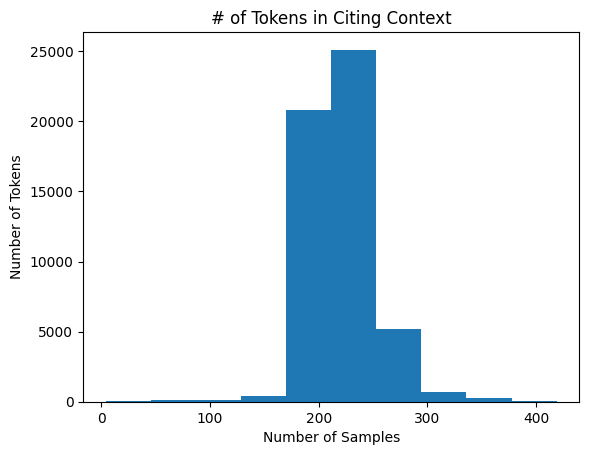

In [46]:
plt.hist(context_lengths)
plt.title('# of Tokens in Citing Context')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Tokens')

In [50]:
holding_lengths = [len(tokenizer(text).input_ids) for text in casehold_df[str(i)] for i in range(2,7)]

KeyError: '215'